In [1]:
import glob
import numpy as np
from MDAnalysis.analysis import rms

## Sage utilities

In [2]:
import numpy as np
import openeye.oechem as oechem
import pandas
import pandas as pd
from geometric.internal import (
    Angle,
    Dihedral,
    Distance,
    OutOfPlane,
    PrimitiveInternalCoordinates,
)
from geometric.molecule import Molecule as GeometricMolecule
from openff.toolkit.topology import Molecule
from rdkit.Chem import TorsionFingerprints
from simtk import unit

# Define the RMSD calculation parameters
RMSD_AUTOMORPH = True  # take into acct symmetry related transformations
RMSD_HEAVY_ONLY = False  # do consider hydrogen atoms for automorphisms
RMSD_OVERLAY = True  # find the lowest possible RMSD


def _compute_internal_coordinate_rmsd(
    molecule: Molecule,
    qm_conformer,#: unit.Quantity,
    mm_conformer,#: unit.Quantity,
):

#     qm_conformer = qm_conformer.value_in_unit(unit.angstrom)
#     mm_conformer = mm_conformer.value_in_unit(unit.angstrom)

    geo_molecule = GeometricMolecule()
    geo_molecule.Data = {
        "resname": ["UNK"] * molecule.n_atoms,
        "resid": [0] * molecule.n_atoms,
        "elem": [atom.element.symbol for atom in molecule.atoms],
        "bonds": [(bond.atom1_index, bond.atom2_index) for bond in molecule.bonds],
        "name": molecule.name,
        "xyzs": [qm_conformer, mm_conformer],
    }

    internal_coordinate_generator = PrimitiveInternalCoordinates(geo_molecule)

    internal_coordinate_types = {
        "Bond": Distance,
        "Angle": Angle,
        "Dihedral": Dihedral,
        "Improper": OutOfPlane,
    }

    internal_coordinates = {
        label: [
            (
                internal_coordinate.value(qm_conformer),
                internal_coordinate.value(mm_conformer),
            )
            for internal_coordinate in internal_coordinate_generator.Internals
            if isinstance(internal_coordinate, internal_coordinate_class)
        ]
        for label, internal_coordinate_class in internal_coordinate_types.items()
    }

    internal_coordinate_rmsd = {}

    for ic_type, ic_values in internal_coordinates.items():

        if len(ic_values) == 0:
            continue

        qm_values, mm_values = zip(*ic_values)

        qm_values = np.array(qm_values)
        mm_values = np.array(mm_values)

        delta = qm_values - mm_values

        rmsd = np.sqrt((delta * delta).mean())
        internal_coordinate_rmsd[ic_type] = float(rmsd)

    return internal_coordinate_rmsd


## Utilities

In [3]:
def get_adjacency_matrix(molecule):
    matrix = np.zeros((molecule.n_atoms, molecule.n_atoms), dtype=int)
    for bond in molecule.bonds:
        i, j = bond.atom1_index, bond.atom2_index
        matrix[i, j] = matrix[j, i] = 1
    return matrix

In [4]:
def read_canonical_mol(i=1):
    from openff.toolkit.topology import Molecule
    smifile = "../00_parsley_benchmark_set/openff_parsley_benchmark.smi"
    with open(smifile, "r") as f:
        smiles = [x.strip() for x in f.readlines()]
    
    smiles = smiles[i - 1]
    offmol = Molecule.from_smiles(smiles, allow_undefined_stereo=True)
    return offmol

### First conformer utilities

In [5]:
def read_first_confs(i=1):
    molname = f"conformers/mol{i:04d}"
    rdname = f"{molname}*_rd.npy"
    oename = f"{molname}*_oe.npy"
    
    rdconfs = []
    oeconfs = []
    
    for file in sorted(glob.glob(rdname)):
        rdconf = np.load(file)
        rdconfs.append(rdconf[0])
        
    for file in sorted(glob.glob(oename)):
        oeconf = np.load(file)
        oeconfs.append(oeconf[0])
        
    toolkits = ["RDKit"] * len(rdconfs) + ["OpenEye"] * len(oeconfs)
        
    confs = np.concatenate([rdconfs, oeconfs])
    return confs, toolkits

In [6]:
def rmsd_first_confs(i=1):
    confs, toolkits = read_first_confs(i=i)
    
    rmsds = np.zeros((len(confs), len(confs)))
    for i, iconf in enumerate(confs):
        for j, jconf in enumerate(confs[i + 1:], i + 1):
            rmsds[i, j] = rmsds[j, i] = rms.rmsd(iconf, jconf, superposition=True)
    return rmsds, toolkits

In [7]:
def internal_rmsd_first_confs(i=1):
    import tqdm
    import json
    from openff.toolkit.topology import Molecule
    
    filename = f"data/irmsd_{i:04d}.json"
    confs, toolkits = read_first_confs(i=i)
    
    try:
        with open(filename, "r") as f:
            rmsds = {k: np.array(v) for k, v in json.load(f).items()}
    except:
        offmol = read_canonical_mol(i=i)
        

        ORDER = ["Bond", "Angle", "Dihedral", "Improper"]
        rmsds = {k: np.zeros((len(confs), len(confs))) for k in ORDER}

        for i, iconf in tqdm.tqdm(enumerate(confs)):
            for j, jconf in enumerate(confs[i + 1:], i + 1):
                irmsd = _compute_internal_coordinate_rmsd(offmol, iconf, jconf)
                for x in ORDER:
                    rmsds[x][i, j] = rmsds[x][j, i] = irmsd[x]
        with open(filename, "w") as f:
            lrmsds = {k: [list(x) for x in v] for k, v in rmsds.items()}
            json.dump(lrmsds, f)
    return rmsds, toolkits

In [8]:
def symmrmsd_first_confs(i=1):
    import tqdm
    import numpy as np
    from spyrmsd.rmsd import symmrmsd
    from openff.toolkit.topology import Molecule
    
    confs, toolkits = read_first_confs(i=i)
    
    filename = f"data/symmrmsd_{i:04d}.npy"
    try:
        rmsds = np.load(filename)
    except:
        offmol = read_canonical_mol(i=i)
        zs = np.array([a.atomic_number for a in offmol.atoms])
        adj = get_adjacency_matrix(offmol)
        
        rmsds = np.zeros((len(confs), len(confs)))

        for i, iconf in tqdm.tqdm(enumerate(confs)):
            for j, jconf in enumerate(confs[i + 1:], i + 1):
                symm = symmrmsd(iconf, jconf, zs, zs, adj, adj, center=True, minimize=True)
                rmsds[i, j] = rmsds[j, i] = symm
        np.save(filename, rmsds)
        
    return rmsds, toolkits

In [9]:
def read_all_confs(i=1):
    molname = f"conformers/mol{i:04d}"
    rdname = f"{molname}*_rd.npy"
    oename = f"{molname}*_oe.npy"
    
    rdconfs = []
    oeconfs = []
    orders = []
    
    for file in sorted(glob.glob(rdname)):
        rdconf = np.load(file)
        rdconfs.append(rdconf)
        i = int(file.split("_m")[1].split("_")[0])
        orders.extend([i] * len(rdconf))
        
    toolkits = ["RDKit"] * len(orders)
        
    for file in sorted(glob.glob(oename)):
        oeconf = np.load(file)
        oeconfs.append(oeconf)
        i = int(file.split("_m")[1].split("_")[0])
        orders.extend([i] * len(oeconf))
        toolkits.extend(["OpenEye"] * len(oeconf))
        
    all_rdconfs = np.concatenate(rdconfs)
    all_oeconfs = np.concatenate(oeconfs)
    confs = np.concatenate([all_rdconfs, all_oeconfs])
    
    rmsds = np.zeros((len(confs), len(confs)))
    for i, iconf in enumerate(confs):
        for j, jconf in enumerate(confs[i + 1:], i + 1):
            rmsds[i, j] = rmsds[j, i] = rms.rmsd(iconf, jconf, superposition=True)
    return rmsds, toolkits, orders

In [10]:
def plot_dih_vs_minrmsd(i=1, linecolor="white", linewidths=0.1,):
    from matplotlib import pyplot as plt
    import numpy as np
    import seaborn as sns
    
    symmrmsd, _ = symmrmsd_first_confs(i)
    all_rmsds, toolkits = internal_rmsd_first_confs(i)
    
    values = np.zeros_like(symmrmsd)
    iu = np.triu_indices(symmrmsd.shape[0], k=1)
    il = np.tril_indices(symmrmsd.shape[0], k=-1)
    values[il] = symmrmsd[il]
    values[iu] = all_rmsds["Dihedral"][iu]
    
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    mask = np.ones_like(symmrmsd, dtype=bool)
    mask[iu] = False
    mask[np.diag_indices(mask.shape[1])] = False
    
    sns.heatmap(values, ax=ax, cmap="gist_heat", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Dihedral RMSD",
                          "location": "right"},
               )
    mask = ~mask
    sns.heatmap(values, ax=ax, cmap="bone", cbar=True,
                linecolor=linecolor, linewidths=linewidths,
                mask=mask, square=True, xticklabels=[],
                yticklabels=[],
                cbar_kws={"label": "Symmetrized RMSD ($\AA$)",
                          "location": "left",
                         },
               )
    
    # lines
    sns.despine(offset=8, ax=ax);

    XJ = len(symmrmsd)
    xi, xj = np.where(np.array(toolkits) == "RDKit")[0][[0, -1]]
    xj += 1
    tickrange = [int((xj - xi)/2), xj, int(xj + (XJ - xj)/2)]
    ticks = ["RDKit", "", "OpenEye"]
    ax.set_yticks(tickrange)
    ax.set_xticks(tickrange)
    ax.set_yticklabels(ticks, fontsize=12, va="center", rotation=90)
    ax.set_xticklabels(ticks, fontsize=12, va="top", ha="center")
    ax.vlines(x=xj, ymin=0, ymax=XJ, lw=3, color="white")
    ax.hlines(y=xj, xmin=0, xmax=XJ, lw=3, color="white")
    

    plt.tight_layout()
    plt.savefig(f"images/first_conformer/mol{i:04d}.png", dpi=300)
    return fig

40it [00:13,  3.06it/s]
40it [01:00,  1.51s/it]
40it [01:01,  1.53s/it]
0it [00:00, ?it/s]Warning: OutOfPlane atoms are the same, ordering is different















1it [00:05,  5.50s/it]Warning: OutOfPlane atoms are the same, ordering is different























2it [00:10,  5.34s/it]Warning: OutOfPlane atoms are the same, ordering is different














3it [00:16,  5.37s/it]Warning: OutOfPlane atoms are the same, ordering is different










4it [00:21,  5.49s/it]Warning: OutOfPlane atoms are the same, ordering is different














6it [00:31,  5.18s/it]Warning: OutOfPlane atoms are the same, ordering is different














8it [00:40,  4.81s/it]Warning: OutOfPlane atoms are the same, ordering is different




















9it [00:45,  4.64s/it]Warning: OutOfPlane atoms are the same, ordering is different













10it [00:49,  4.60s/it]Warning: OutOfPlane atoms are the same, ordering is different















11it [00:53,  4.54s/it]Warning: OutOfPlane atoms are the same, ordering is different
















12it [00:58,  4.59s/it]Warning: OutOfPlane atoms are the same, ordering is different












13it [01:03,  4.51s/it]Warning: OutOfPlane atoms are the same, ordering is different








14it [01:07,  4.55s/it]Warning: OutOfPlane atoms are the same, ordering is different








15it [01:11,  4.33s/it]Warning: OutOfPlane atoms are the same, ordering is different












16it [01:15,  4.20s/it]Warning: OutOfPlane atoms are the same, ordering is different












17it [01:18,  3.99s/it]Warning: OutOfPlane atoms are the same, ordering is different












18it [01:22,  3.80s/it]Warning: OutOfPlane atoms are the same, ordering is different












19it [01:25,  3.65s/it]Warning: OutOfPlane atoms are the same, ordering is different












20it [01:28,  3.40s/it]Warning: OutOfPlane atoms are the same, ordering is different


















21it [01:31,  3.36s/it]Warning: OutOfPlane atoms are the same, ordering is different
















22it [01:34,  3.32s/it]Warning: OutOfPlane atoms are the same, ordering is different
















23it [01:39,  3.61s/it]Warning: OutOfPlane atoms are the same, ordering is different
















24it [01:42,  3.60s/it]Warning: OutOfPlane atoms are the same, ordering is different
















25it [01:46,  3.52s/it]Warning: OutOfPlane atoms are the same, ordering is different














26it [01:48,  3.28s/it]Warning: OutOfPlane atoms are the same, ordering is different














27it [01:51,  3.09s/it]Warning: OutOfPlane atoms are the same, ordering is different














28it [01:54,  2.94s/it]Warning: OutOfPlane atoms are the same, ordering is different










29it [01:56,  2.81s/it]Warning: OutOfPlane atoms are the same, ordering is different














30it [01:59,  2.73s/it]Warning: OutOfPlane atoms are the same, ordering is different








31it [02:01,  2.64s/it]Warning: OutOfPlane atoms are the same, ordering is different








32it [02:03,  2.39s/it]Warning: OutOfPlane atoms are the same, ordering is different








33it [02:04,  2.10s/it]Warning: OutOfPlane atoms are the same, ordering is different








34it [02:06,  1.87s/it]Warning: OutOfPlane atoms are the same, ordering is different




35it [02:07,  1.74s/it]Warning: OutOfPlane atoms are the same, ordering is different






36it [02:08,  1.57s/it]Warning: OutOfPlane atoms are the same, ordering is different






40it [02:10,  3.26s/it]
40it [00:21,  1.83it/s]
40it [01:20,  2.01s/it]
40it [00:14,  2.76it/s]
0it [00:00, ?it/s]Warning: OutOfPlane atoms are the same, ordering is different

1it [00:03,  3.85s/it]Warning: OutOfPlane atoms are the same, ordering is different

2it [00:07,  3.84s/it]Warning: OutOfPlane atoms are the same, ordering is different





























6it [00:21,  3.52s/it]Warning: OutOfPlane atoms are the same, ordering is different






7it [00:24,  3.35s/it]Warning: OutOfPlane atoms are the same, ordering is different

8it [00:27,  3.15s/it]Warning: OutOfPlane atoms are the same, ordering is different






9it [00:30,  3.06s/it]Warning: OutOfPlane atoms are the same, ordering is different

10it [00:32,  2.88s/it]Warning: OutOfPlane atoms are the same, ordering is different






11it [00:35,  2.78s/it]Warning: OutOfPlane atoms are the same, ordering is different



















































12it [00:38,  2.81s/it]Warning: OutOfPlane atoms are the same, ordering is different























13it [00:41,  2.87s/it]Warning: OutOfPlane atoms are the same, ordering is different



14it [00:43,  2.76s/it]Warning: OutOfPlane atoms are the same, ordering is different
























15it [00:46,  2.73s/it]Warning: OutOfPlane atoms are the same, ordering is different






















17it [00:51,  2.63s/it]Warning: OutOfPlane atoms are the same, ordering is different






















40it [01:15,  1.88s/it]
40it [00:39,  1.02it/s]
0it [00:00, ?it/s]Warning: OutOfPlane atoms are the same, ordering is different






































1it [00:05,  5.92s/it]Warning: OutOfPlane atoms are the same, ordering is different





















2it [00:11,  5.55s/it]Warning: OutOfPlane atoms are the same, ordering is different







































3it [00:16,  5.33s/it]Warning: OutOfPlane atoms are the same, ordering is different


























4it [00:21,  5.44s/it]Warning: OutOfPlane atoms are the same, ordering is different


































5it [00:27,  5.41s/it]Warning: OutOfPlane atoms are the same, ordering is different









6it [00:32,  5.22s/it]Warning: OutOfPlane atoms are the same, ordering is different

































7it [00:37,  5.44s/it]Warning: OutOfPlane atoms are the same, ordering is different



























8it [00:42,  5.19s/it]Warning: OutOfPlane atoms are the same, ordering is different



















9it [00:48,  5.38s/it]Warning: OutOfPlane atoms are the same, ordering is different






























10it [00:53,  5.21s/it]Warning: OutOfPlane atoms are the same, ordering is different






























11it [00:57,  4.87s/it]Warning: OutOfPlane atoms are the same, ordering is different





12it [01:01,  4.59s/it]Warning: OutOfPlane atoms are the same, ordering is different































13it [01:05,  4.39s/it]Warning: OutOfPlane atoms are the same, ordering is different





























14it [01:08,  4.15s/it]Warning: OutOfPlane atoms are the same, ordering is different







15it [01:13,  4.16s/it]Warning: OutOfPlane atoms are the same, ordering is different






















16it [01:16,  4.05s/it]Warning: OutOfPlane atoms are the same, ordering is different


























17it [01:20,  4.00s/it]Warning: OutOfPlane atoms are the same, ordering is different



18it [01:24,  3.92s/it]Warning: OutOfPlane atoms are the same, ordering is different



19it [01:27,  3.80s/it]Warning: OutOfPlane atoms are the same, ordering is different




















40it [02:06,  3.16s/it]
40it [00:11,  3.50it/s]
40it [01:04,  1.62s/it]


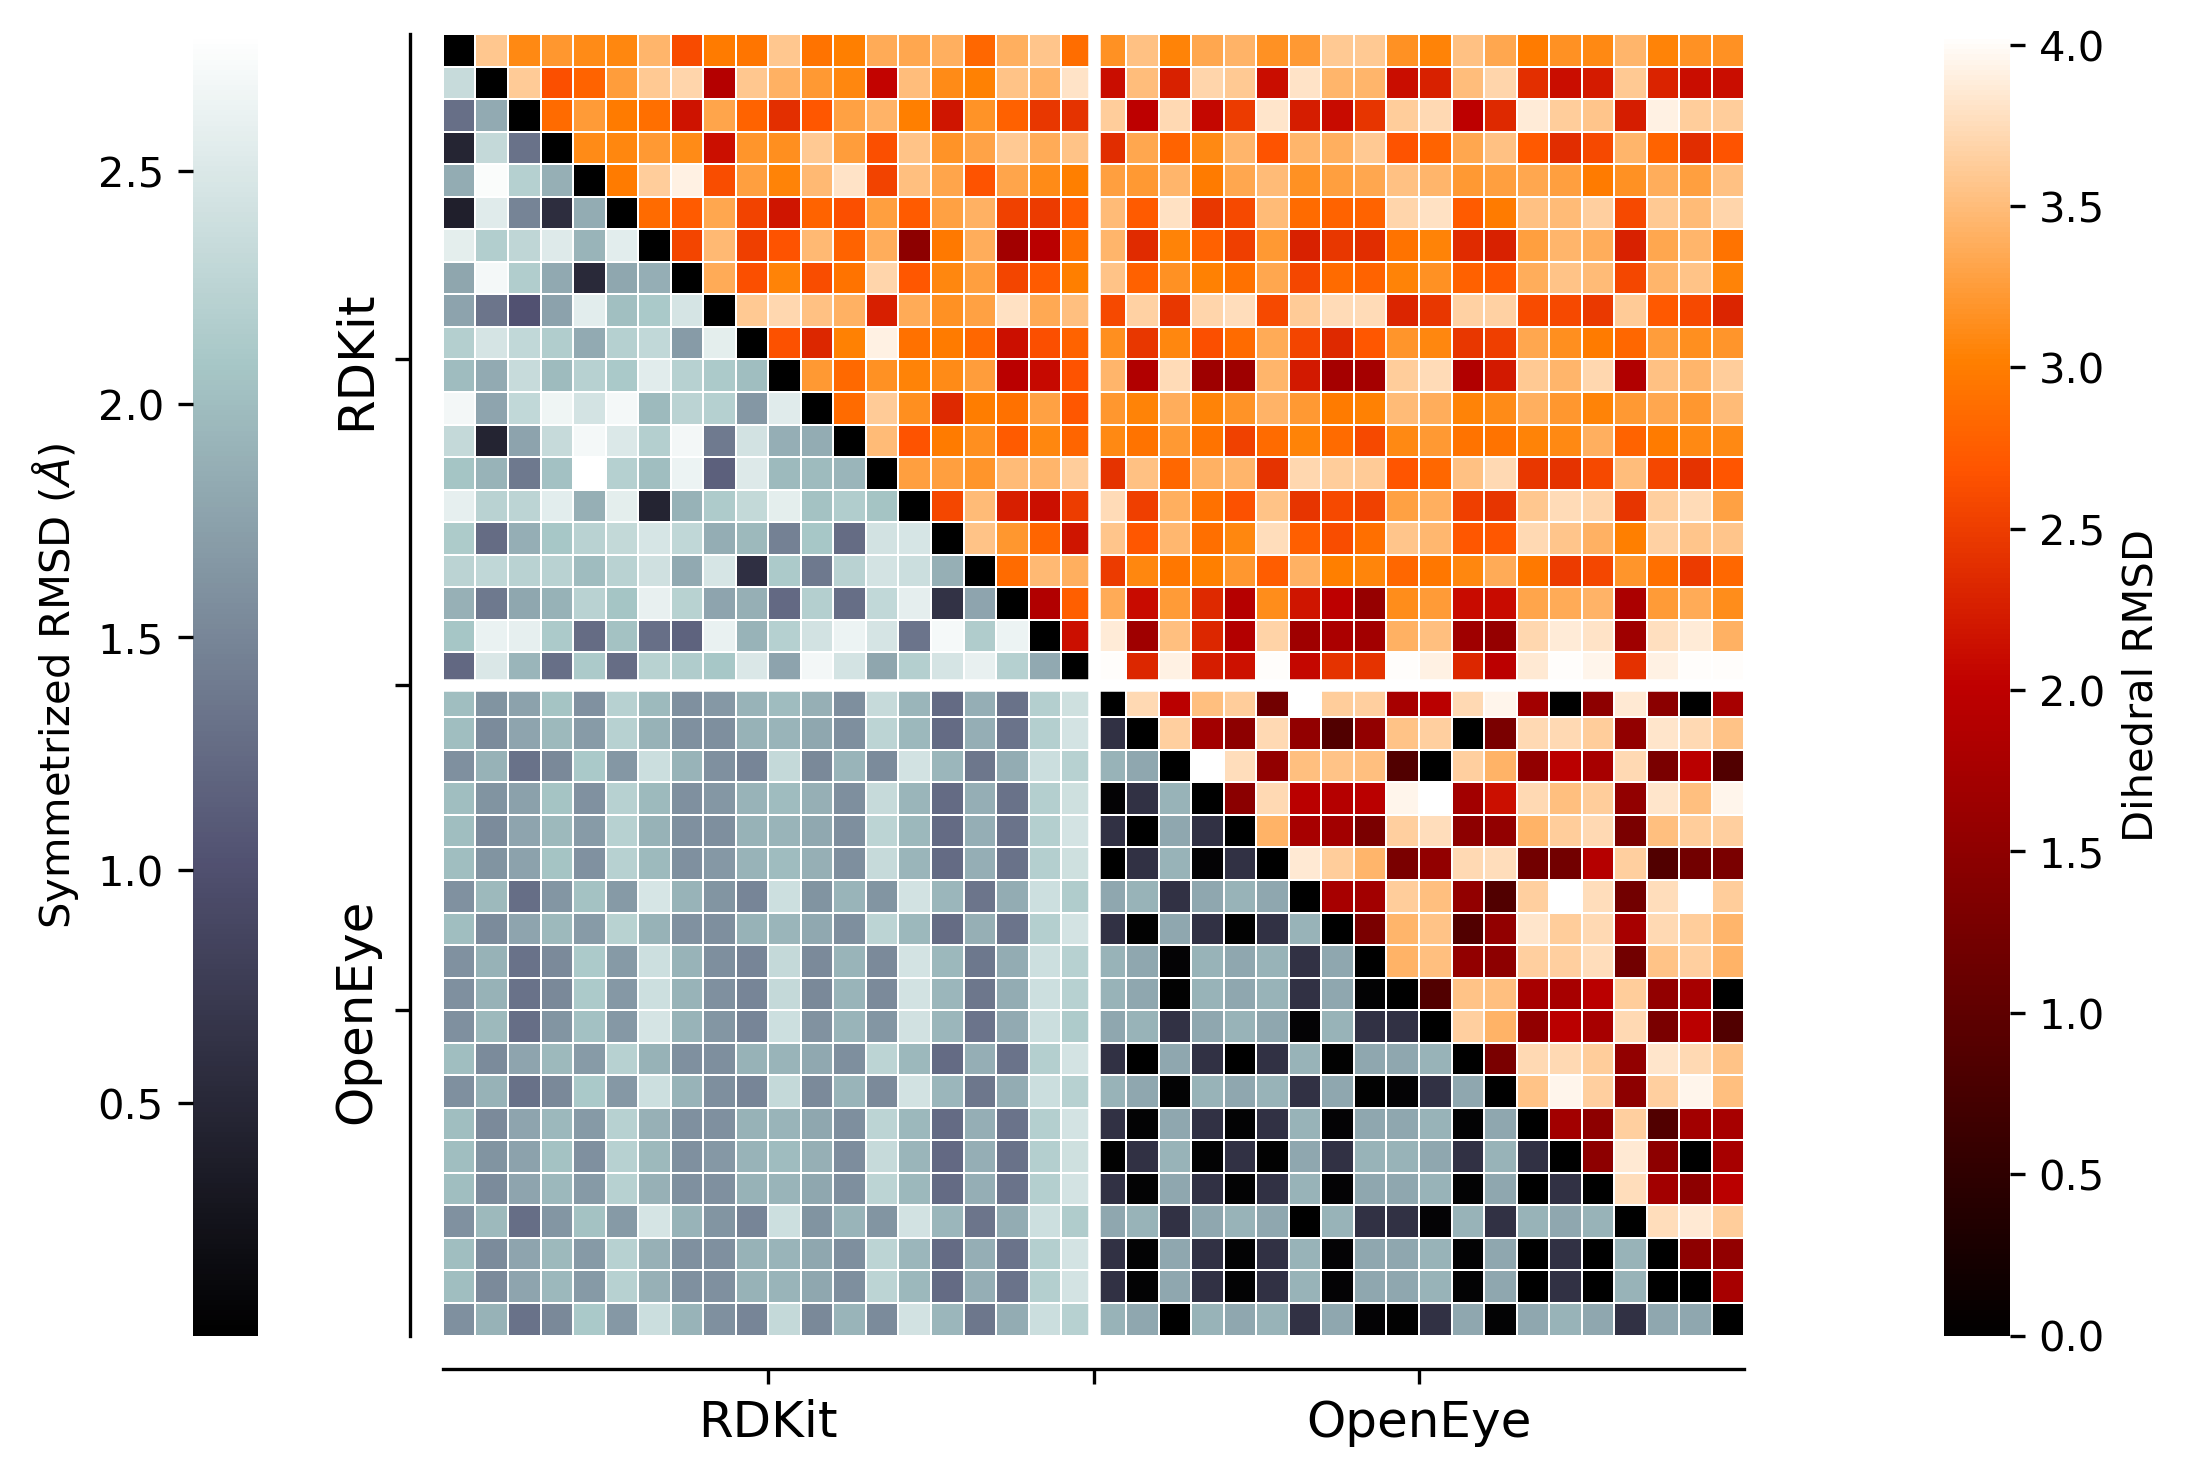

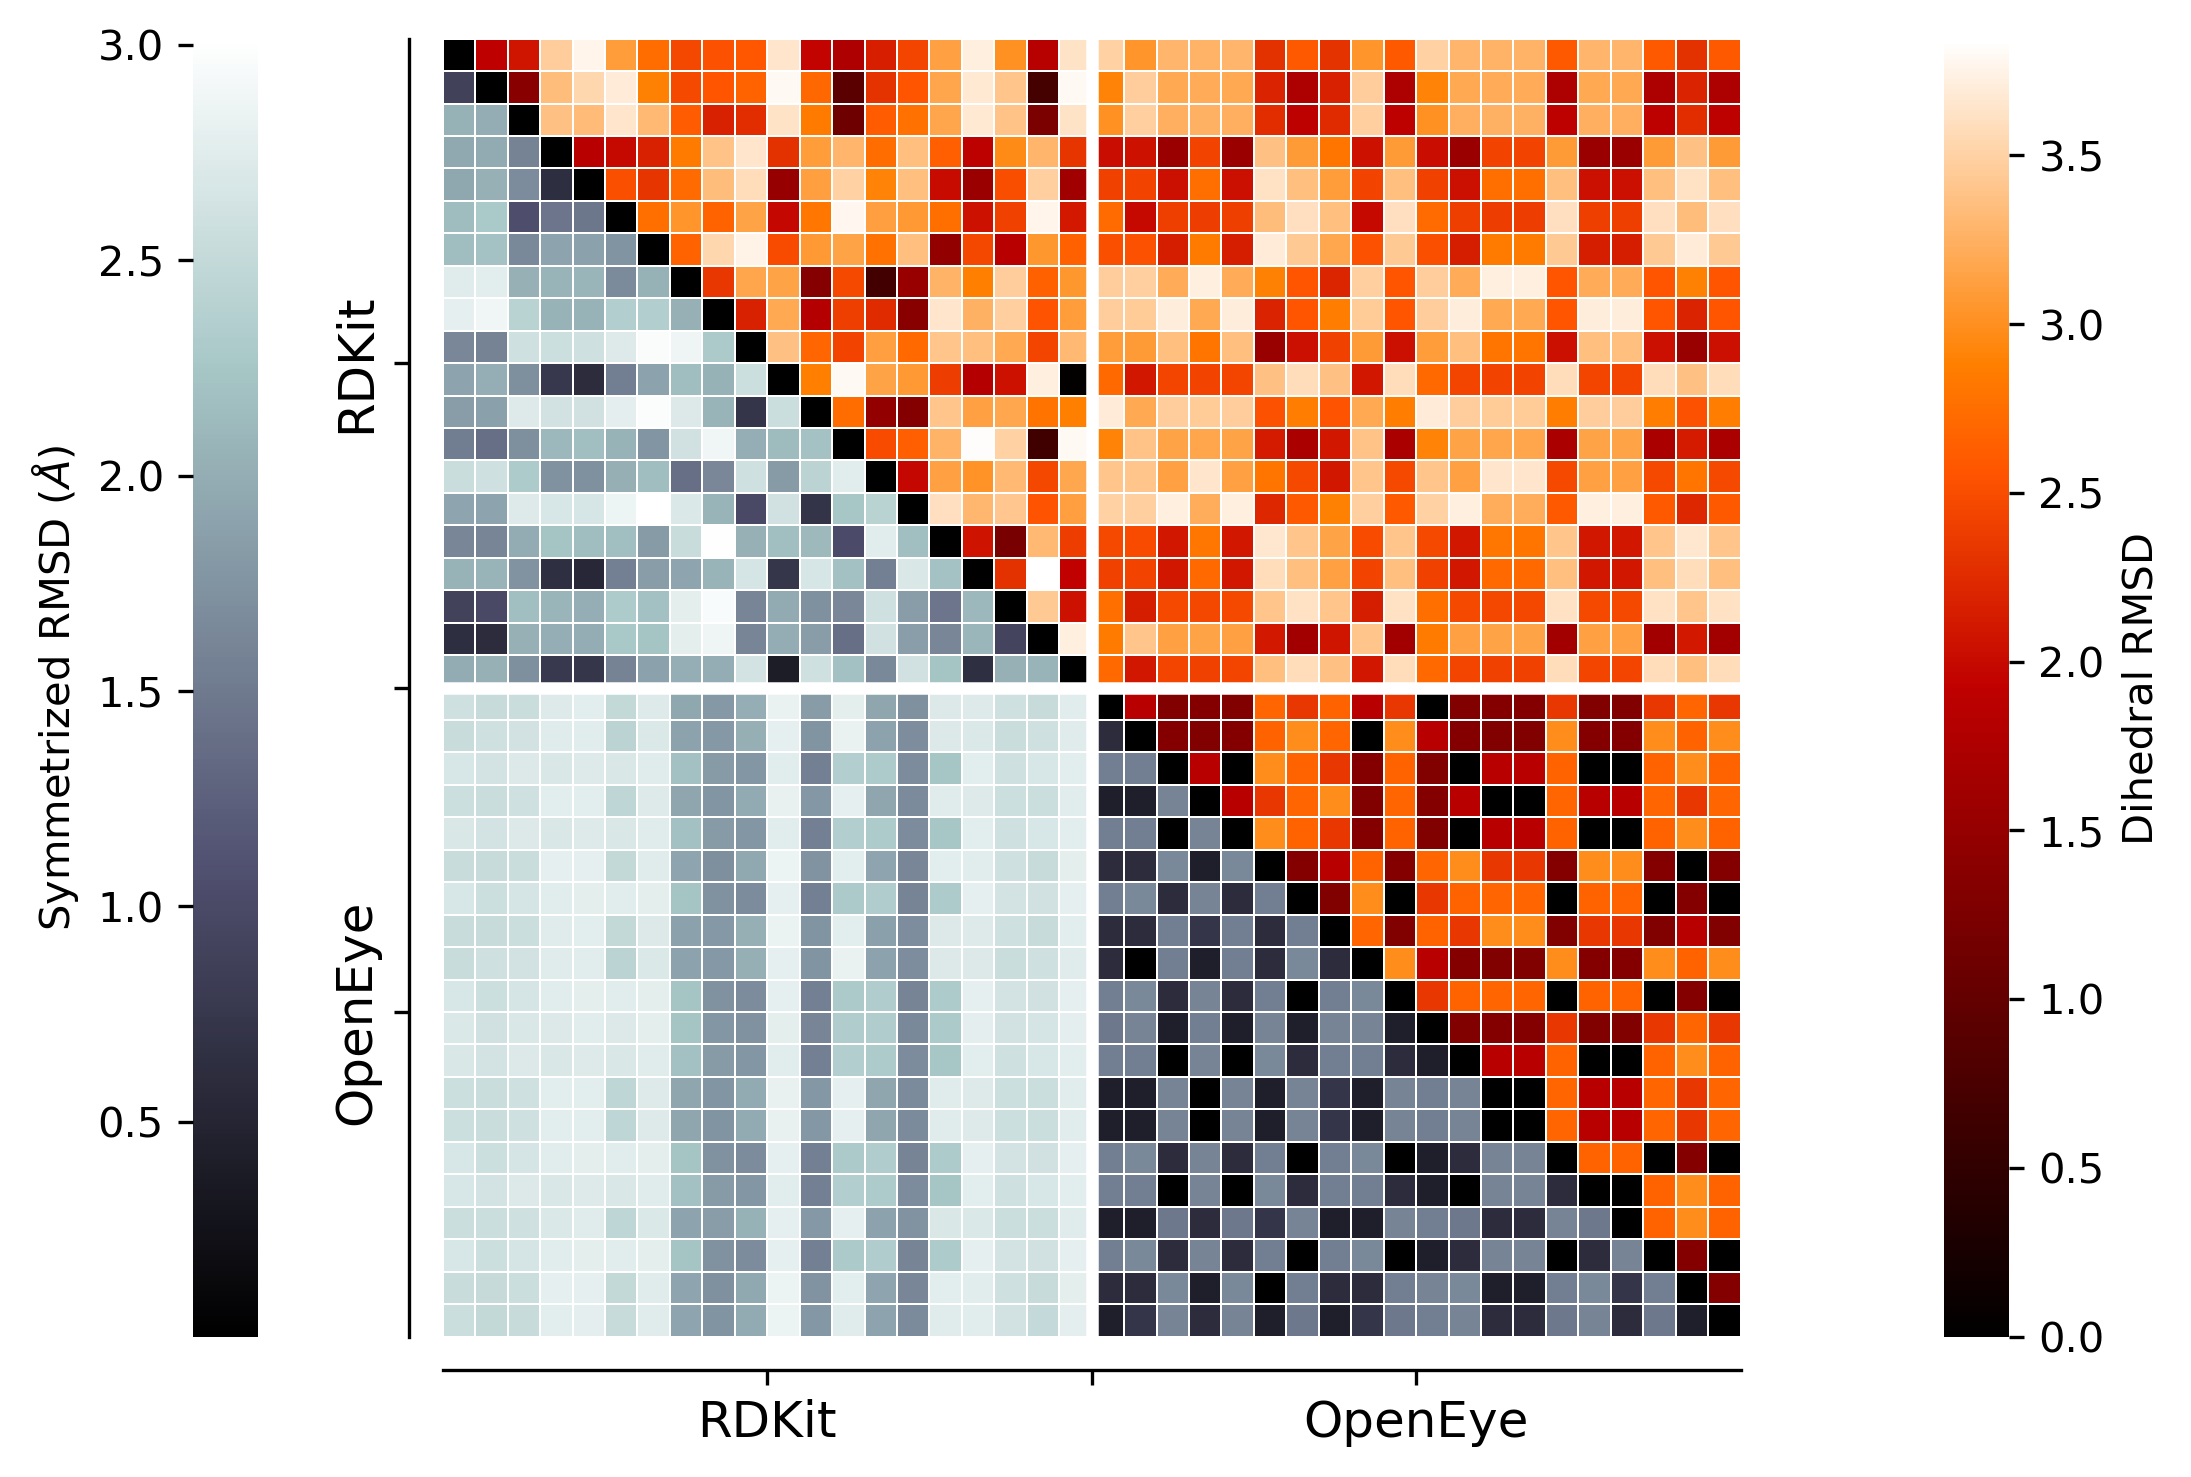

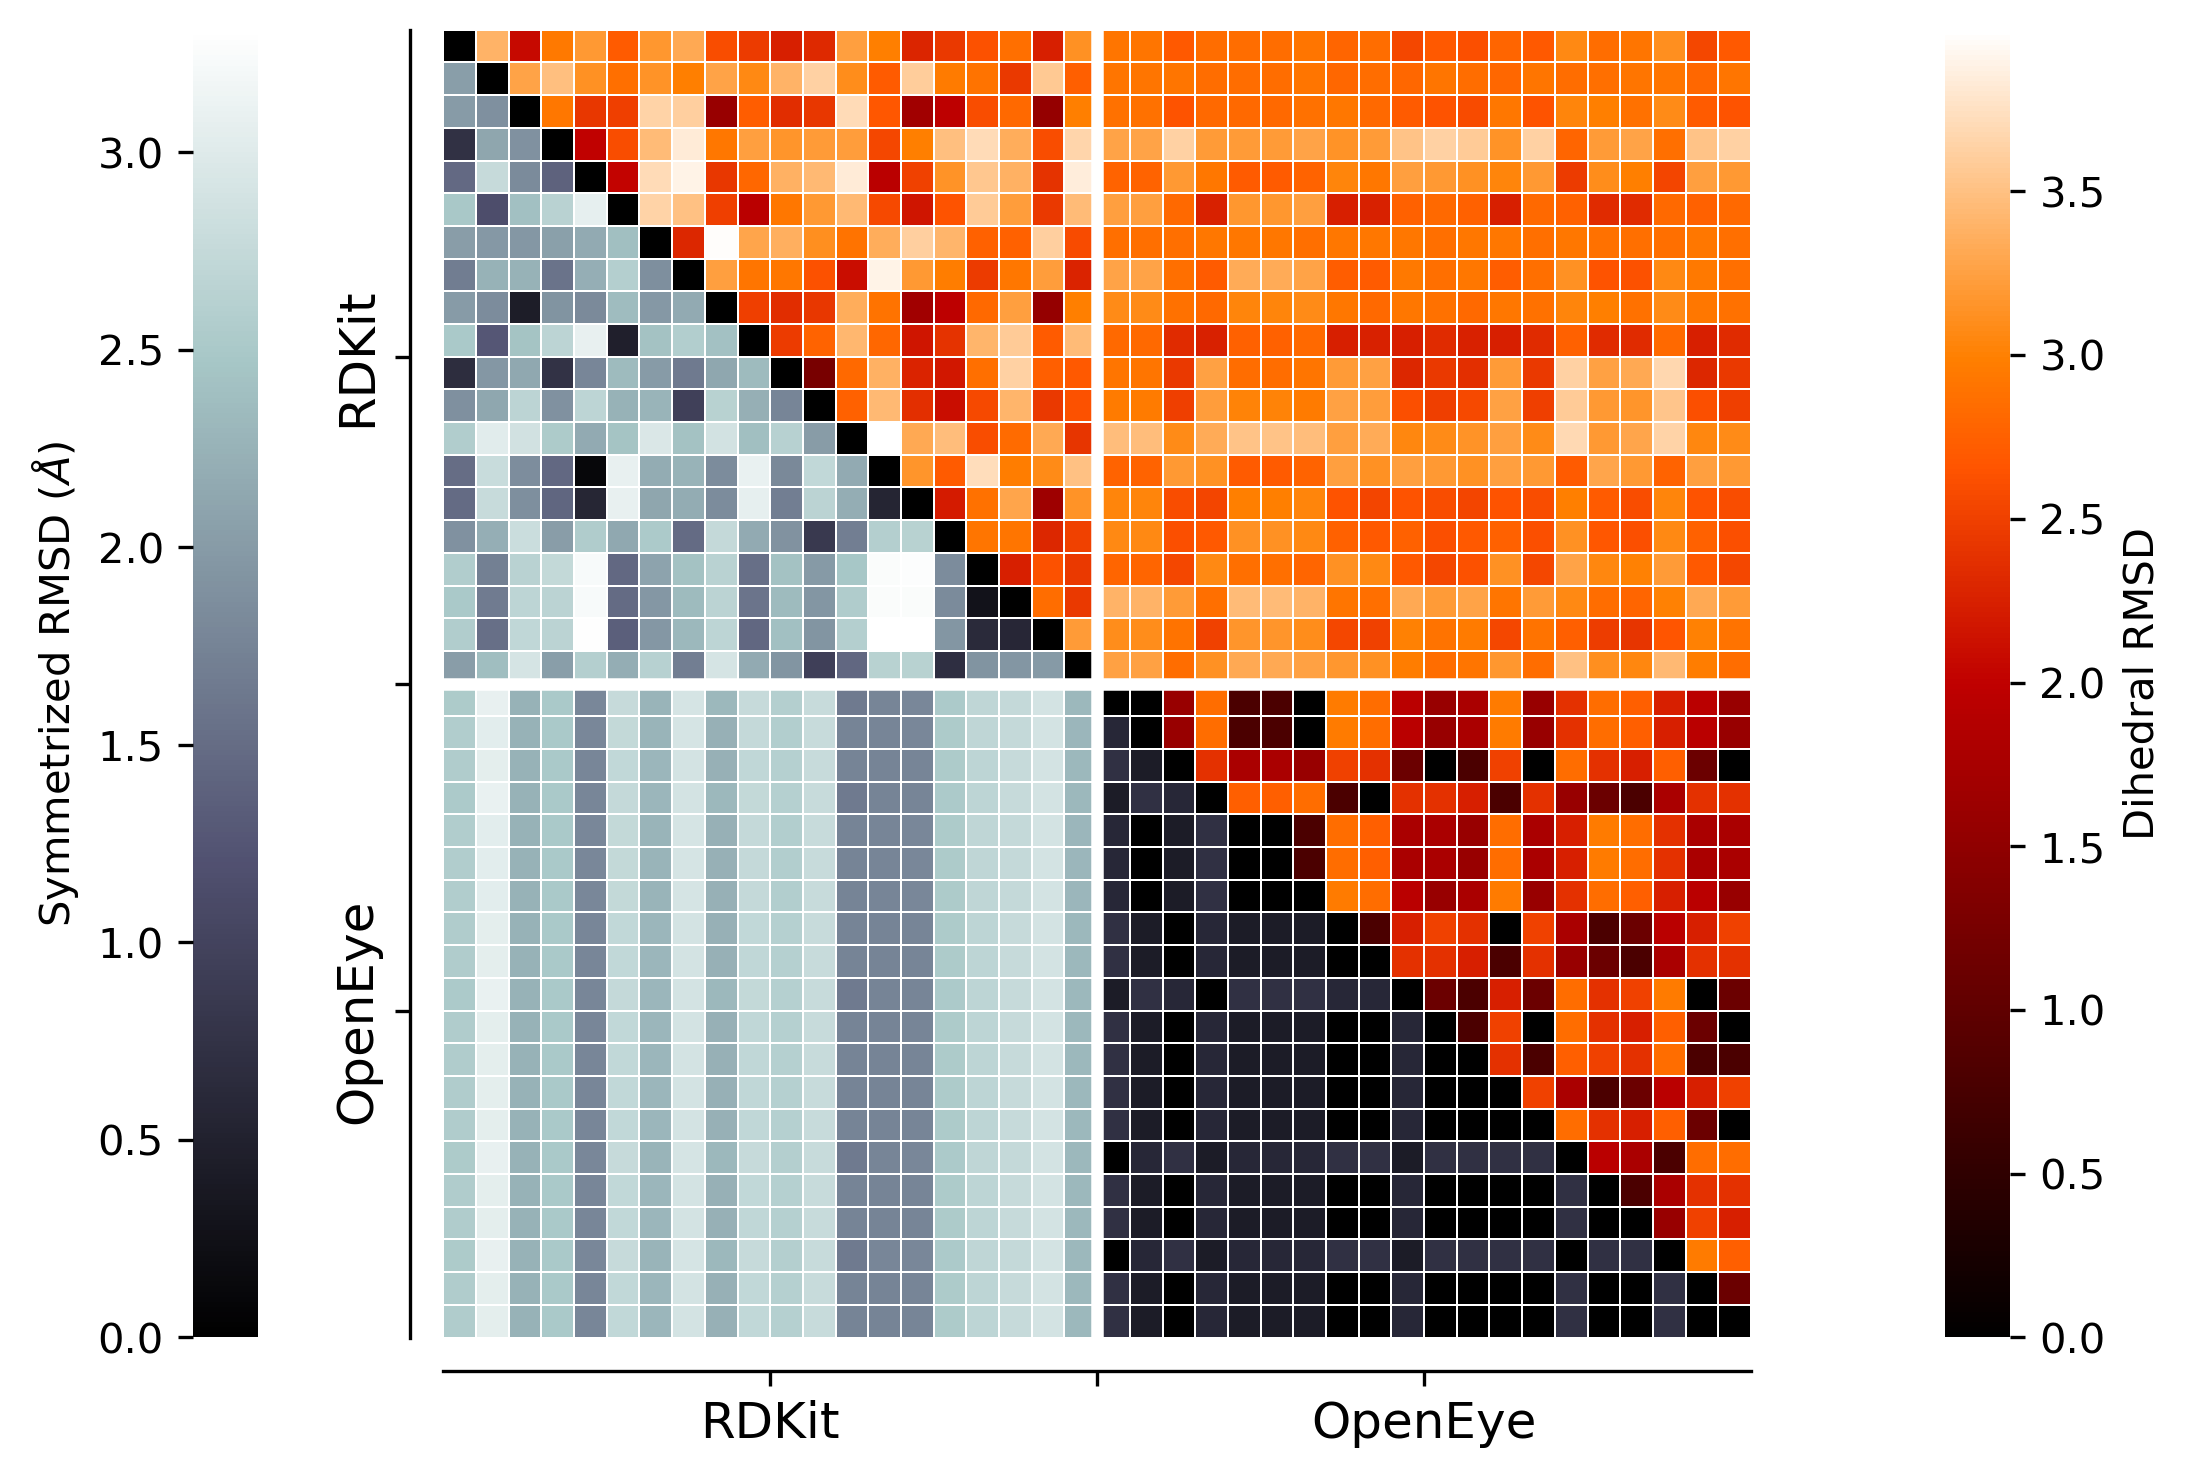

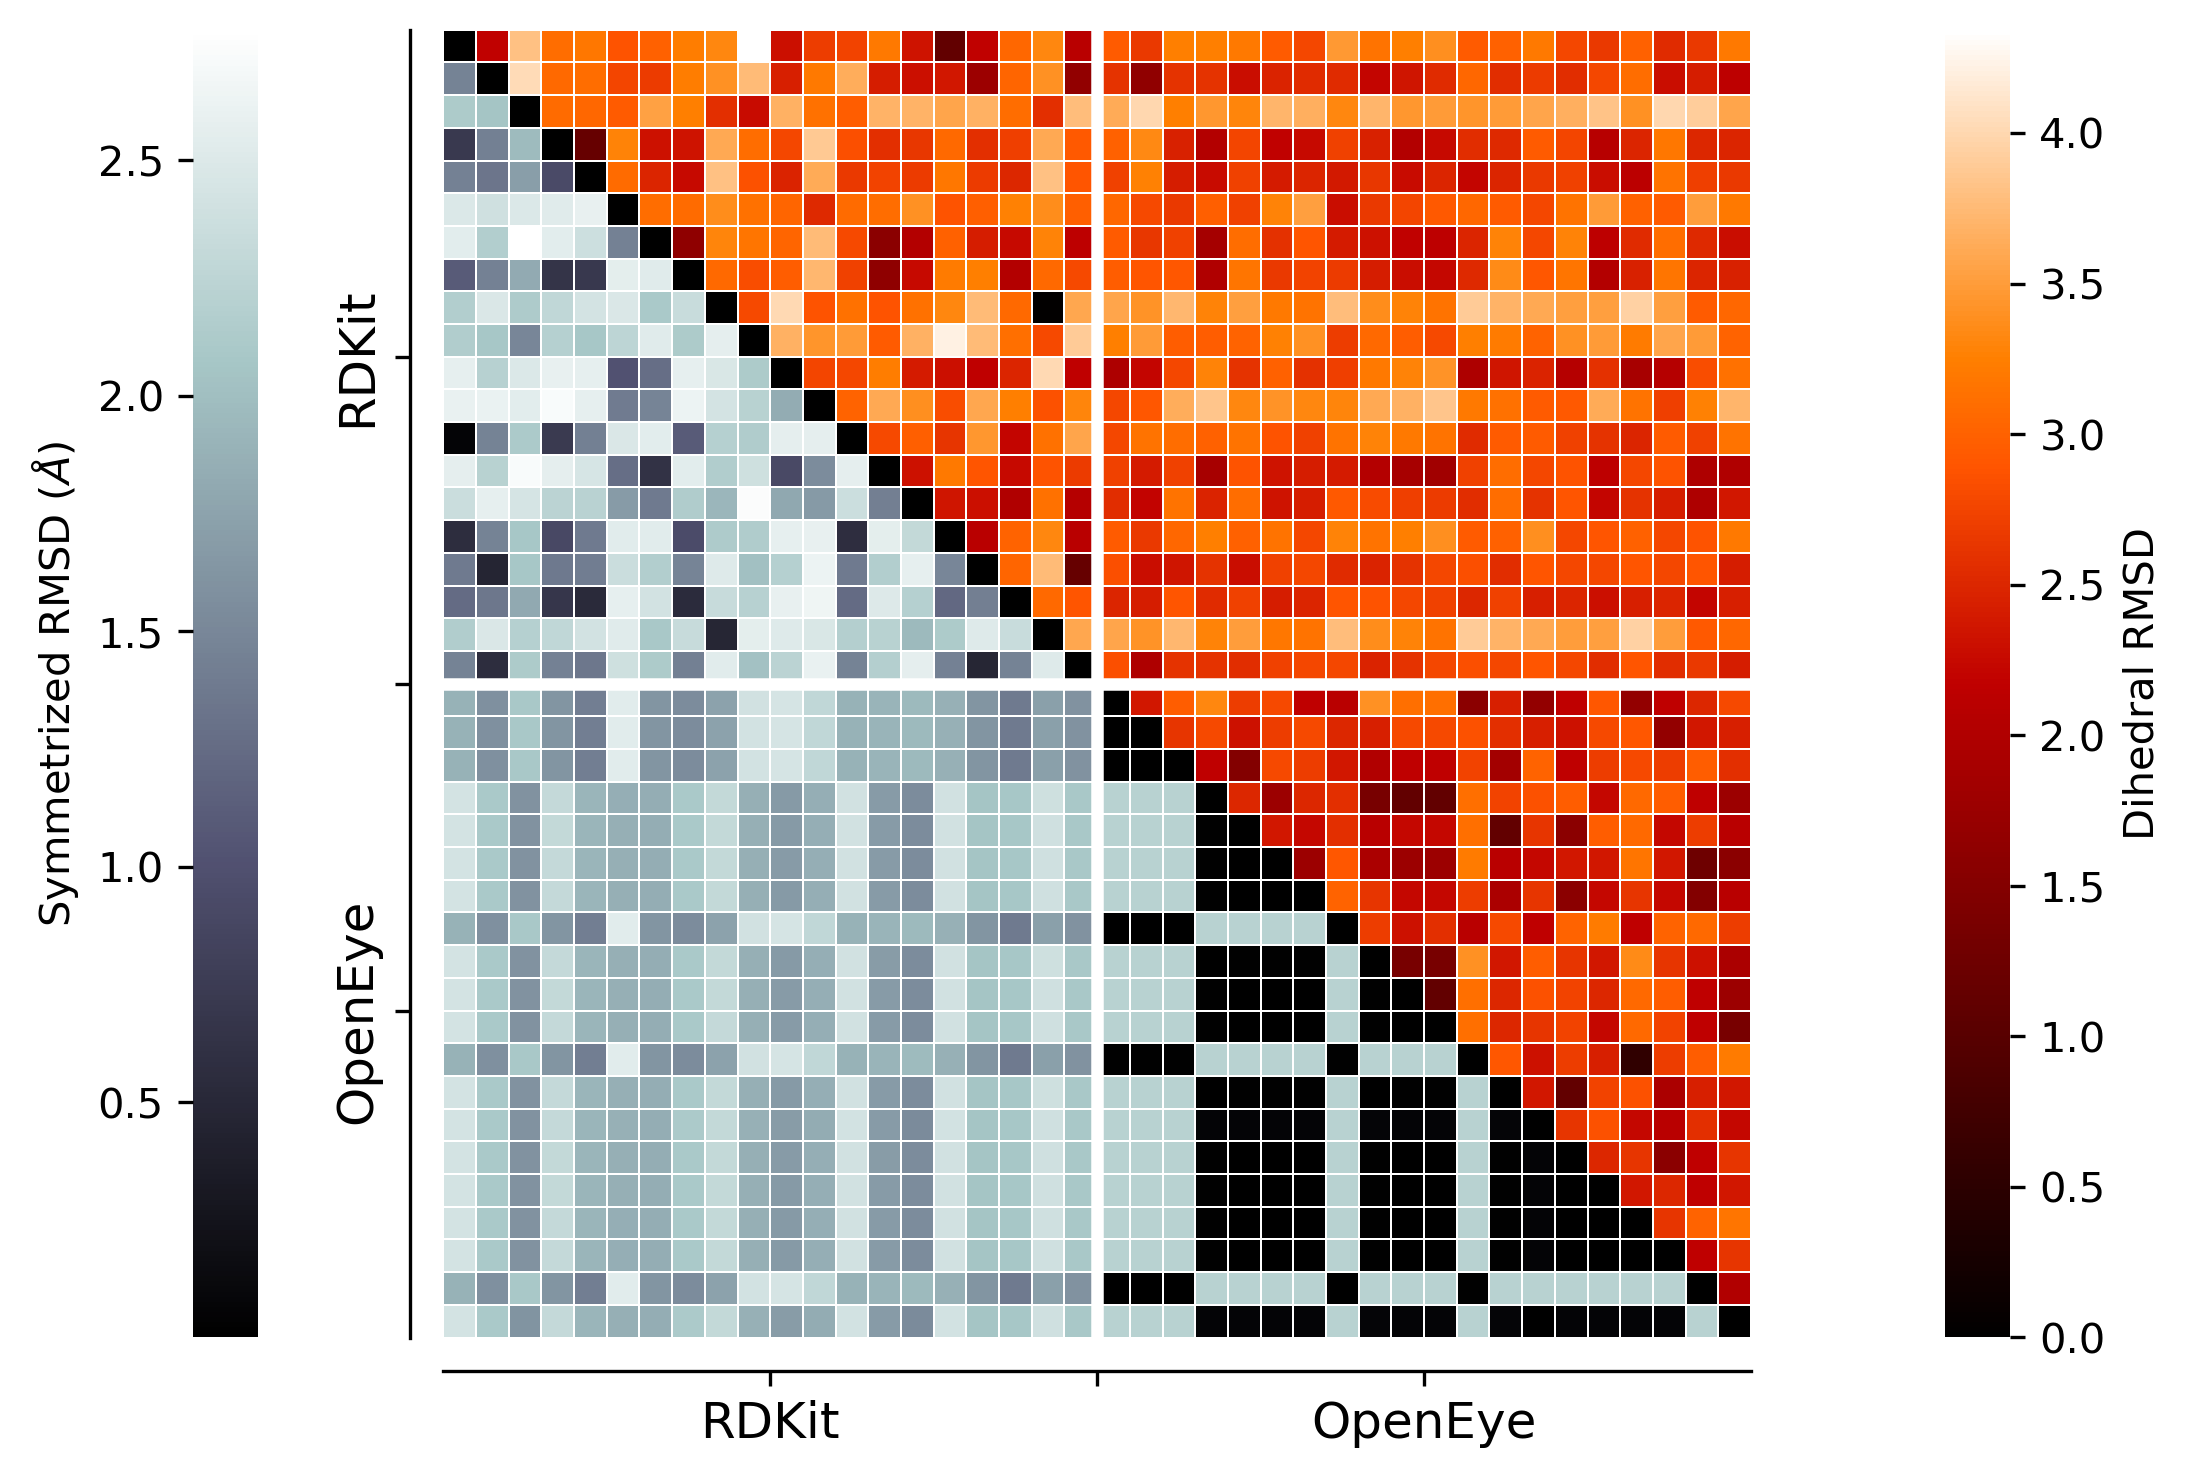

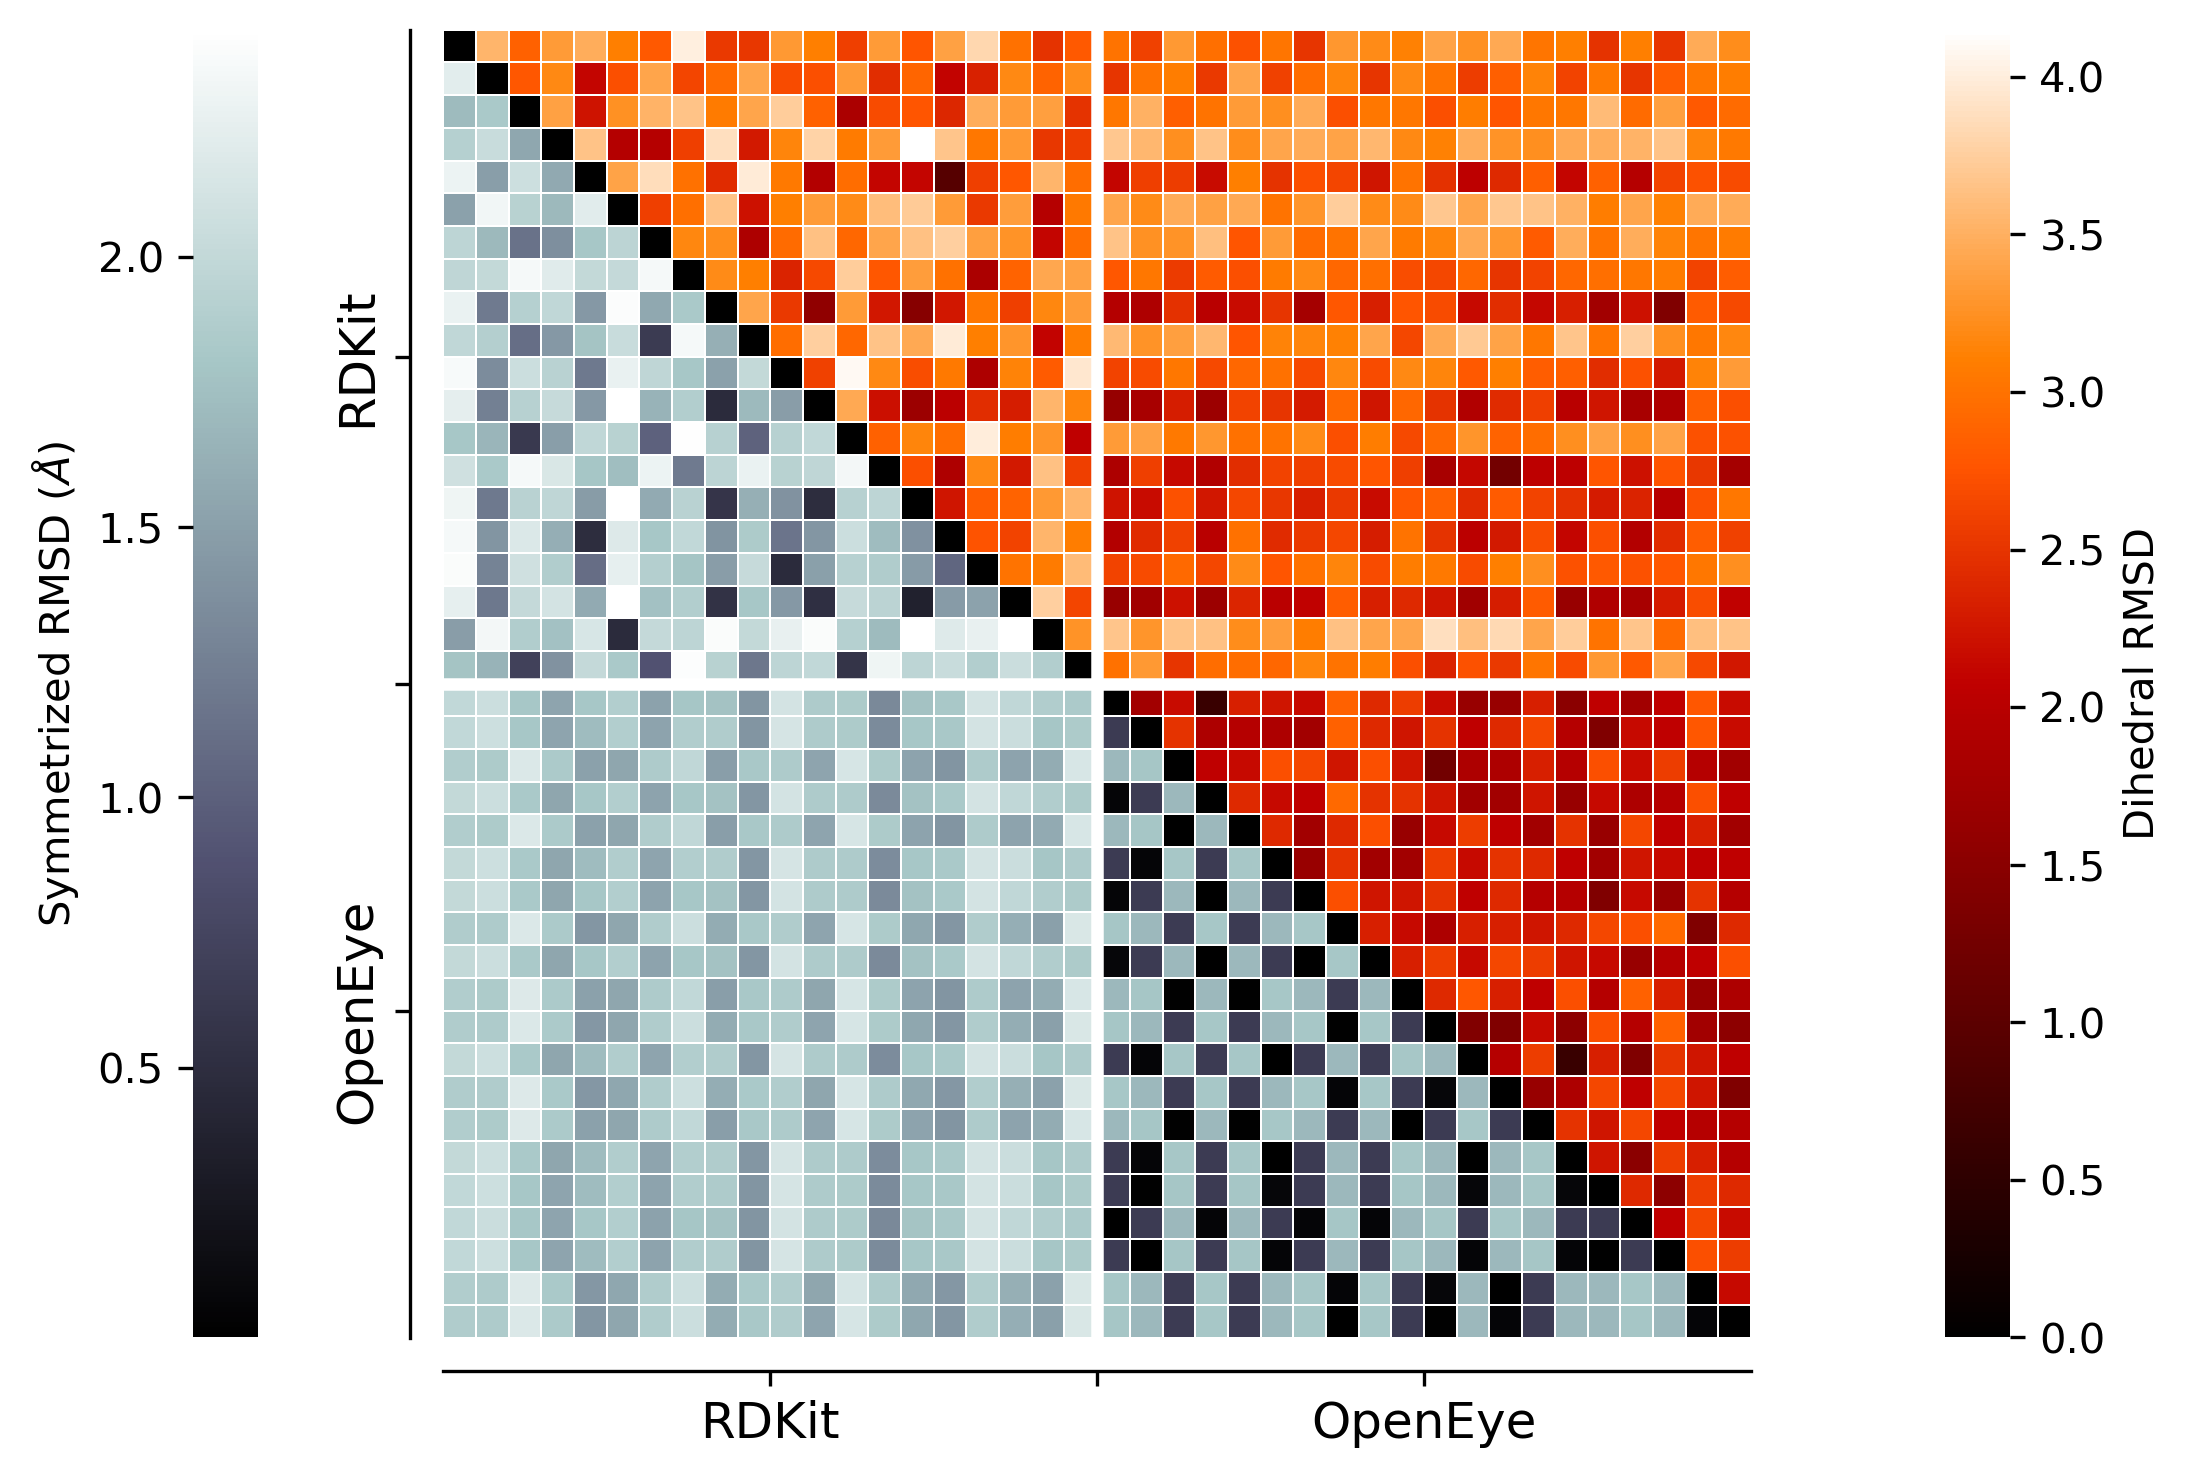

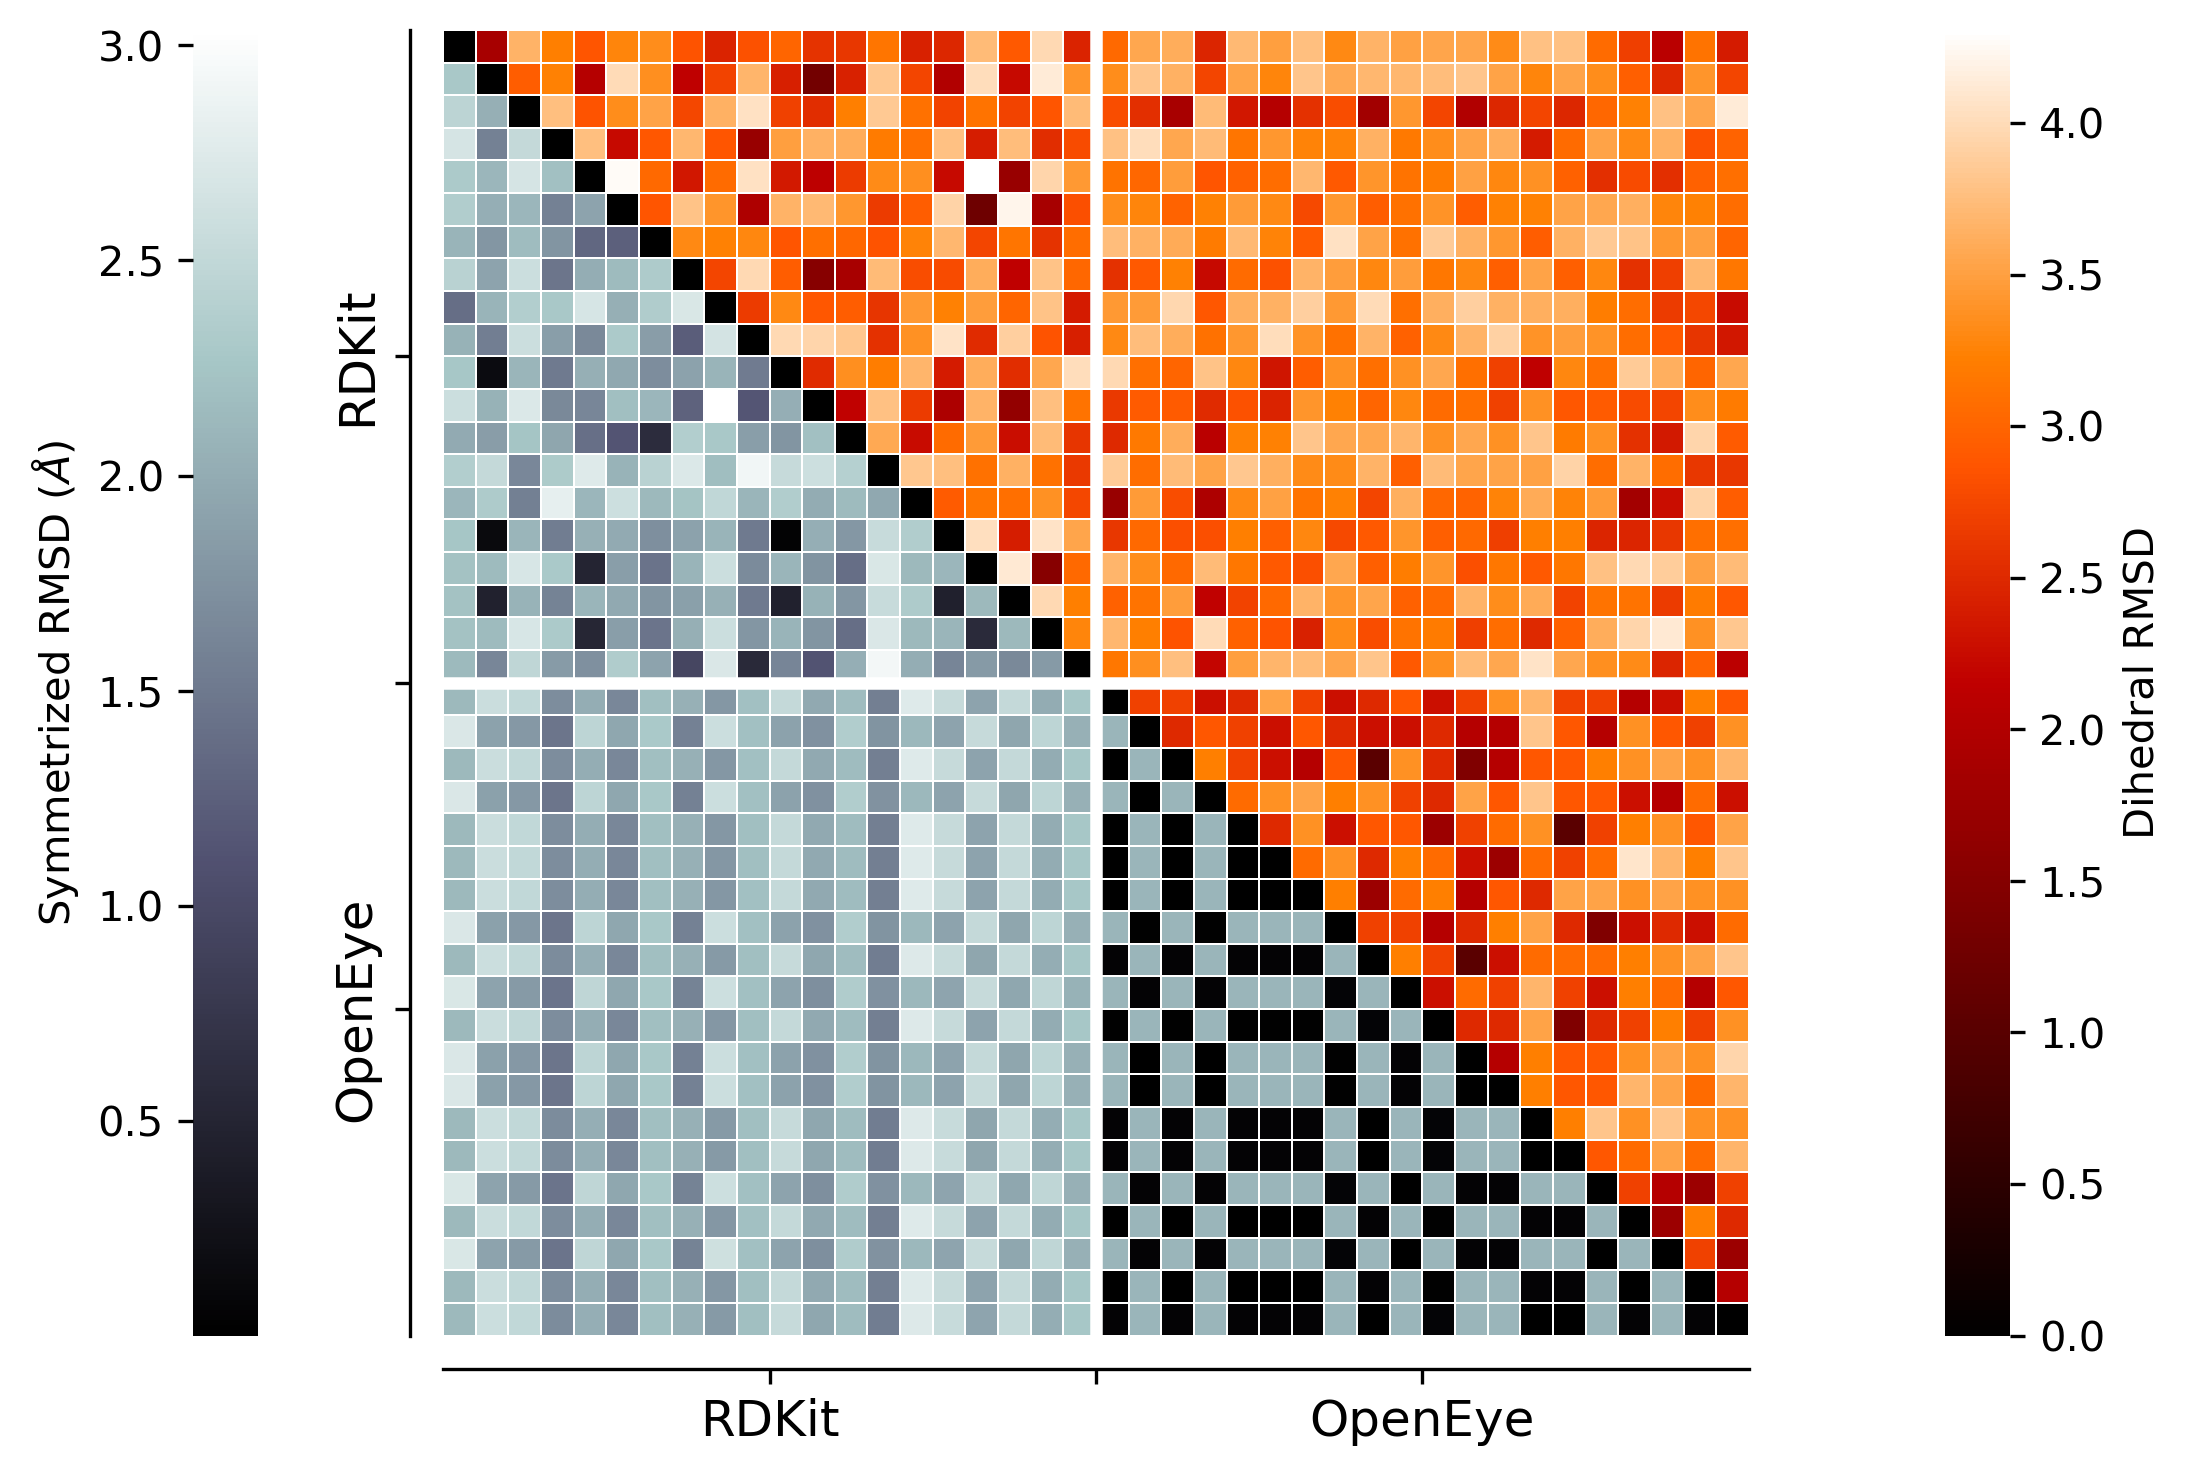

In [11]:
for i in range(92, 98):
    try:
        plot_dih_vs_minrmsd(i=i+1)
    except:
        pass

## Molecule 4

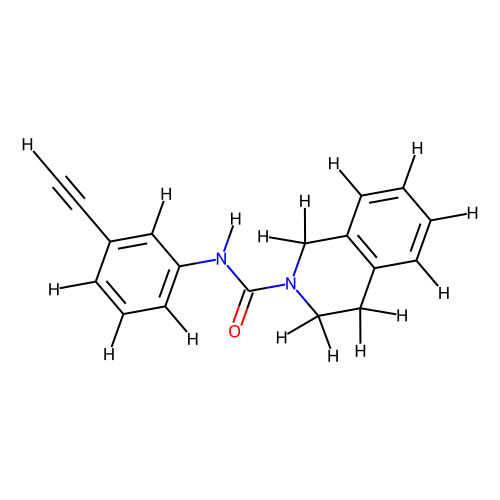

In [14]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG=True 
IPythonConsole.molSize = 500, 500

mol = Molecule.from_smiles("C#Cc1cccc(c1)NC(=O)N2CCc3ccccc3C2")
mol.visualize(backend="rdkit")

## Straight RMSD

In [4]:
rmsd_1, orders_1, toolkits_1 = read_mol()

In [5]:
frmsd_1, ftoolkits_1 = read_first_mol(1)

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
xi, xj = np.where(np.array(ftoolkits_1) == "RDKit")[0][[0, -1]]

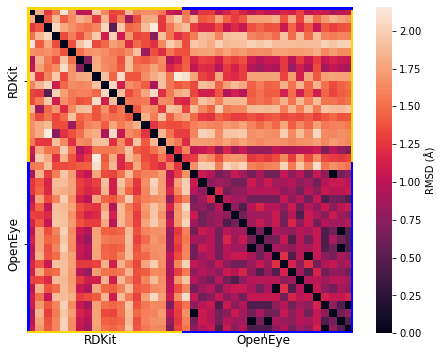

In [8]:
# fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(frmsd_1, ax=ax, square=True, cbar_kws={"label": "RMSD (Å)"})
XJ = len(frmsd_1)
tickrange = [int((xj - xi)/2), int(xj + (XJ - xj)/2)]
ax.set_yticks(tickrange)
ax.set_xticks(tickrange)
ax.set_yticklabels(["RDKit", "OpenEye"], fontsize=12, va="center")
ax.set_xticklabels(["RDKit", "OpenEye"], fontsize=12, va="center")
ax.vlines(x=-0.2, ymin=xi, ymax=xj, lw=8, color="gold")
ax.vlines(x=-0.2, ymin=xj, ymax=XJ, lw=8, color="blue")
ax.vlines(x=XJ+0.2, ymin=xi, ymax=xj, lw=8, color="gold")
ax.vlines(x=XJ+0.2, ymin=xj, ymax=XJ, lw=8, color="blue")
ax.hlines(y=-0.2, xmin=xi, xmax=xj, lw=8, color="gold")
ax.hlines(y=-0.2, xmin=xj, xmax=XJ, lw=8, color="blue")
ax.hlines(y=XJ+0.2, xmin=xi, xmax=xj, lw=8, color="gold")
ax.hlines(y=XJ+0.2, xmin=xj, xmax=XJ, lw=8, color="blue")

# plt.tight_layout()
# plt.savefig("compare_first_conformer_rd_vs_oe_mol1.png", dpi=300)

In [77]:
from openff.toolkit.topology import Molecule

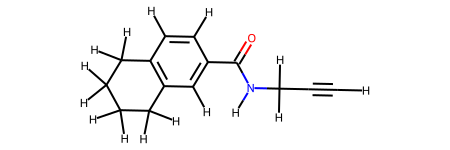

In [78]:
Molecule.from_smiles("C#CCNC(=O)c1ccc2c(c1)CCCC2")

## Internal RMSDS

In [57]:
irmsd, itoolkits = symmrmsd_first_confs()

40it [00:19,  2.08it/s]


In [58]:
from matplotlib import pyplot as plt

%matplotlib inline

<AxesSubplot:>

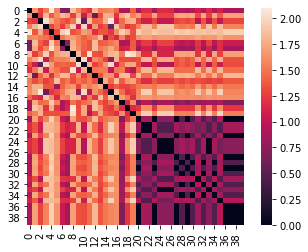

In [59]:
import seaborn as sns

sns.heatmap(irmsd, square=True)

In [55]:
from openff.toolkit.topology import Molecule

offmol = Molecule.from_smiles("CC")
offmol.bonds[0]

Bond(atom1 index=0, atom2 index=1)